# Examples - Day I

Refer to the "XSUITE introduction notebook" for additional XSUITE references.

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xplt

## Example 1 - 90 deg FODO lattice

### Read MAD-X sequence from file (using cpymad)

In [3]:
from cpymad.madx import Madx
mad = Madx()
mad.option(echo=True)
name = "machine"
mad.call(file = 'E_1_1.mdx')

mad.use(f'{name}')



  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.12.04               +
  + Execution date: 2024.07.15 18:22:41      +
  ++++++++++++++++++++++++++++++++++++++++++++
!TITLE Converted from LATTICE EDITOR: E_1_1.opt[*].  Thu Jun 27 18:29:15 2024



!  Kinetic energy=999.489 MeV, mass=0.510999 MeV

!  BetaX=9.75689 m,  AlphaX=-2.39517,  BetaY=1.8565 m,  AlphaY=0.5309 

!  DispX=0 m,  DispPX=0,  DispY=0 m,  DispPY=0 



OPTION, -ECHO;

  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

  Number of warnings: 0

  ++++++++++++++++++++++++++++++++++++++++++++
  +          MAD-X finished normally         +
  ++++++++++++++++++++++++++++++++++++++++++++


### Import a line from a MAD-X sequence

In [4]:
line = xt.Line.from_madx_sequence(mad.sequence.machine,
                                  deferred_expressions=True, 
                                 )

### Define the reference particule

In [5]:
line.particle_ref = xt.Particles(mass0=xt.ELECTRON_MASS_EV,
                            gamma0=mad.sequence.machine.beam.gamma,
                                )

In [6]:
line.build_tracker()

### Machine Layout

In [8]:
line.get_table().rows[:].show()

name            s element_type isthick isreplica parent_name iscollective
machine$start   0 Marker         False     False None               False
qf              0 Quadrupole      True     False None               False
od0           0.3 Drift           True     False None               False
qd              3 Quadrupole      True     False None               False
od0:0         3.3 Drift           True     False None               False
machine$end     6 Marker         False     False None               False
_end_point      6                False     False None               False


In [9]:
sv = line.survey()
sv.rows[:].show()

name          X Y   Z theta phi psi   s drift_length angle tilt
machine$start 0 0   0     0   0   0   0            0     0    0
qf            0 0   0     0   0   0   0          0.3     0    0
od0           0 0 0.3     0   0   0 0.3          2.7     0    0
qd            0 0   3     0   0   0   3          0.3     0    0
od0:0         0 0 3.3     0   0   0 3.3          2.7     0    0
machine$end   0 0   6     0   0   0   6            0     0    0
_end_point    0 0   6     0   0   0   6            0     0    0


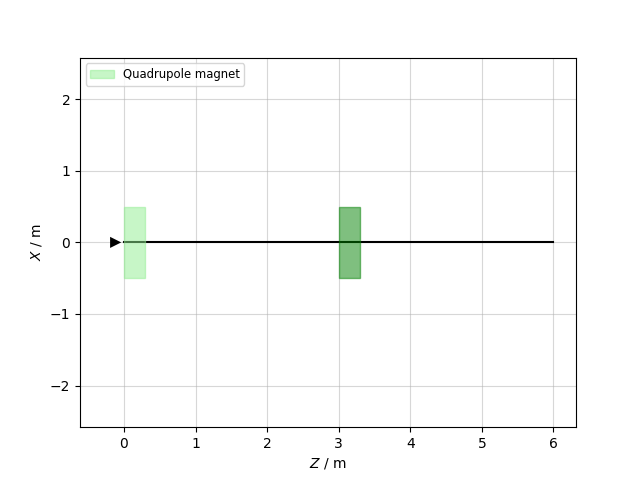

In [11]:
plot = xplt.FloorPlot(sv.rows[:], line, 
                #labels = True,
                boxes={  
                    "qf": dict(color="lightgreen"), 
                    "qd": dict(color="green"), 
                },
            )
plt.legend(fontsize='small', loc='upper left')

### Set the quadrupole strengths with variables

In [13]:
line.element_refs['qf']._info()

#  element_refs['qf']._get_value()
   element_refs['qf'] = Quadrupole(k1=1.63, k1s=0, length=0.3, num_multipole_kicks=0, _order=5, inv_factorial_order=0.00833, knl=array([0., 0., 0., 0., 0., 0.]), ksl=array([0., 0., 0., 0., 0., 0.]), _sin_rot_s=-999, _cos_rot_s=-999, _shift_x=0, _shift_y=0, _shift_s=0)

#  element_refs['qf']._expr is None

#  element_refs['qf'] does not influence any target



In [16]:
# The reference strenght was set in the MAD-X file
k1_init = line.element_refs['qf'].k1._get_value()
k1_init

1.626679186

In [17]:
line.vars['kqf'] = k1_init
line.vars['kqd'] = -k1_init
line.element_refs['qf'].k1 = line.vars['kqf']
line.element_refs['qd'].k1 = line.vars['kqd']

### Match the phase advances to 90 degree

In [18]:
# Match tunes and chromaticities to assigned values
opt = line.match(
    method='4d',
    vary=[
        xt.VaryList(['kqf', 'kqd'], step=1e-8, tag='quad'),
    ],
    targets = [
        xt.TargetSet(qx=1/4, qy=1/4, tol=1e-6, tag='tune'),
    ])

Matching: model call n. 1               



In [19]:
opt.target_status()
opt.vary_status()

Target status:                          
id state tag  tol_met     residue current_val target_val description                         
 0 ON    tune    True 2.67737e-08        0.25       0.25 'qx', val=0.25, tol=1e-06, weight=10
 1 ON    tune    True 2.67737e-08        0.25       0.25 'qy', val=0.25, tol=1e-06, weight=10
Vary status:                 
id state tag  met name lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    quad OK  kqf  None            1.62668 None              1.62668 1e-08      1
 1 ON    quad OK  kqd  None           -1.62668 None             -1.62668 1e-08      1


### Twiss

In [20]:
tw = line.twiss(method='4d')

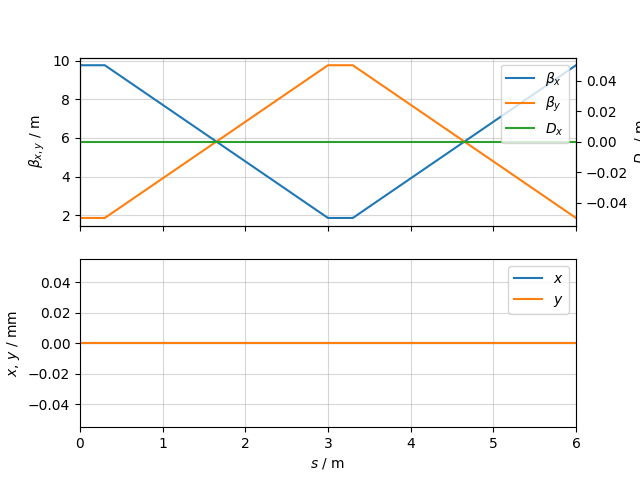

In [21]:
xplt.TwissPlot(tw)

## EXAMPLE 2 - 60 deg FODO lattice

In [23]:
# We make a copy of the first set of elements
element_line2 = {}

for elem in line.get_table().rows[:].name[:-1]:
    element_line2[elem + '_0'] = line.element_refs[elem]._get_value()

In [24]:
line2 = xt.Line(elements = element_line2, 
               element_names = list(element_line2.keys())
               )
line2.insert_element('start_line', xt.Marker(), at_s = 0)
# Define reference particle
line2.particle_ref = xt.Particles(energy0=1e9, mass0=xt.ELECTRON_MASS_EV)

line2.build_tracker()

In [25]:
line2.get_table().rows[:].show()

name              s element_type isthick isreplica parent_name iscollective
start_line        0 Marker         False     False None               False
machine$start_0   0 Marker         False     False None               False
qf_0              0 Quadrupole      True     False None               False
od0_0           0.3 Drift           True     False None               False
qd_0              3 Quadrupole      True     False None               False
od0:0_0         3.3 Drift           True     False None               False
machine$end_0     6 Marker         False     False None               False
_end_point        6                False     False None               False


### Set the quadrupole strengths with variables

In [26]:
line2.vars['kqf'] = k1_init
line2.vars['kqd'] = -k1_init
line2.element_refs['qf_0'].k1 = line2.vars['kqf']
line2.element_refs['qd_0'].k1 = line2.vars['kqd']

### Match the phase advances to 60 degree

In [27]:
# Match tunes and chromaticities to assigned values
opt = line2.match(
    method='4d',
    vary=[
        xt.VaryList(['kqf', 'kqd'], step=1e-8, tag='quad'),
    ],
    targets = [
        xt.TargetSet(qx=1/6, qy=1/6, tol=1e-6, tag='tune'),
    ])

Matching: model call n. 12               



In [28]:
opt.target_status()
opt.vary_status()

Target status:                           
id state tag  tol_met     residue current_val target_val description                             
 0 ON    tune    True 3.45793e-09    0.166667   0.166667 'qx', val=0.166667, tol=1e-06, weight=10
 1 ON    tune    True 3.45793e-09    0.166667   0.166667 'qy', val=0.166667, tol=1e-06, weight=10
Vary status:                 
id state tag  met name lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    quad OK  kqf  None            1.15017 None              1.62668 1e-08      1
 1 ON    quad OK  kqd  None           -1.15017 None             -1.62668 1e-08      1


### Twiss

In [29]:
tw = line2.twiss(method='4d')
tw_init = tw.get_twiss_init('start_line')

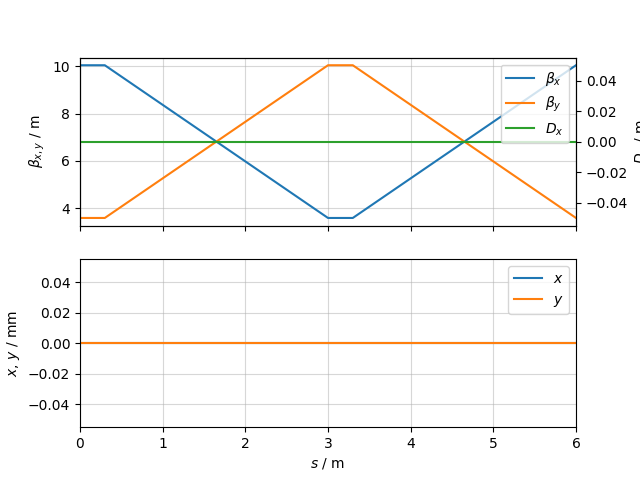

In [30]:
xplt.TwissPlot(tw)

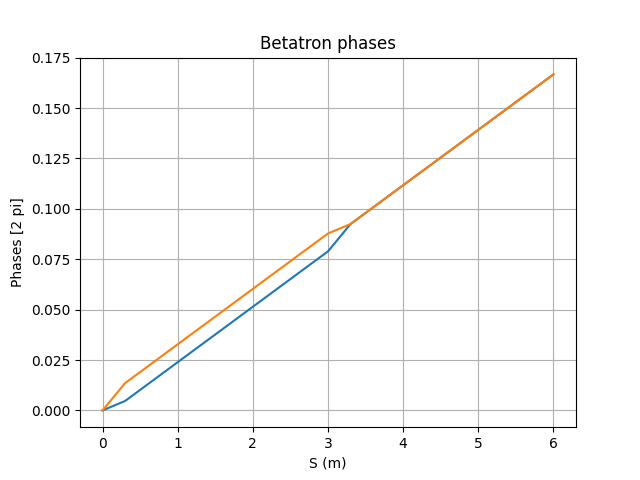

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(tw['s'], tw['mux'])
ax.plot(tw['s'], tw['muy'])

ax.set(xlabel='S (m)', ylabel=r'Phases [2 pi]',
       title='Betatron phases')
ax.grid()

fig.savefig("fodo_60.png")
plt.show()


## Example 3 : 60 deg. FODO Matching Insert 

- Start with a sequence of five 60 deg. FODO cells extended by a 2.3 meter drift
- Use the last three FODO cells as a matching insert (‘unleash’ 6 matching quads)
- Match TWISS at the lattice end to: bx/y = 12 meters  and  ax/y = 0 
- Make sure the maximum betas do not exceed 30 meters 


### Construction of the line

In [33]:
FODO_1 = {}
FODO_2 = {}
FODO_3 = {}
FODO_4 = {}
FODO_5 = {}
drift = {'dr': xt.Drift(length = 2.3)}


for elem in line2.get_table().rows[:].name[:-1]:
    FODO_1[elem[:-2] + '_1'] = line2.element_refs[elem]._get_value().copy()
    FODO_2[elem[:-2] + '_2'] = line2.element_refs[elem]._get_value().copy()
    FODO_3[elem[:-2] + '_3'] = line2.element_refs[elem]._get_value().copy()
    FODO_4[elem[:-2] + '_4'] = line2.element_refs[elem]._get_value().copy()
    FODO_5[elem[:-2] + '_5'] = line2.element_refs[elem]._get_value().copy()


In [37]:
line3 = xt.Line(
    elements = {**FODO_1, **FODO_2, **FODO_3, **FODO_4, **FODO_5, **drift},
    element_names = list(FODO_1.keys())+list(FODO_2.keys()) +  list(FODO_3.keys())+list(FODO_4.keys()) +list(FODO_5.keys())+ list(drift.keys())
                )
line3.particle_ref = xt.Particles(energy0=1e9, mass0=xt.ELECTRON_MASS_EV)
line3.insert_element('start_line', xt.Marker(), at_s = 0)

line3.build_tracker()

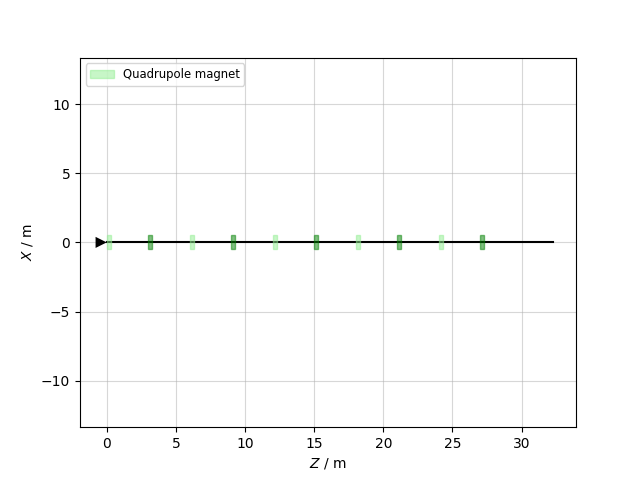

In [39]:
sv = line3.survey()

plot = xplt.FloorPlot(sv.rows[:], line3, 
                #labels = True,
                boxes={  
                    "qf": dict(color="lightgreen"), 
                    "qd": dict(color="green"), 
                },
            )
plt.legend(fontsize='small', loc='upper left')

In [35]:
line3.get_table().rows[:].show()

name               s element_type isthick isreplica parent_name iscollective
start_line         0 Marker         False     False None               False
start_li_1         0 Marker         False     False None               False
machine$start_1    0 Marker         False     False None               False
qf_1               0 Quadrupole      True     False None               False
od0_1            0.3 Drift           True     False None               False
qd_1               3 Quadrupole      True     False None               False
od0:0_1          3.3 Drift           True     False None               False
machine$end_1      6 Marker         False     False None               False
start_li_2         6 Marker         False     False None               False
machine$start_2    6 Marker         False     False None               False
qf_2               6 Quadrupole      True     False None               False
od0_2            6.3 Drift           True     False None               False

In [40]:
tw = line3.twiss(method='4d'  ,  
                 init = tw_init,
                 start = 'start_line', 
                 end = '_end_point')

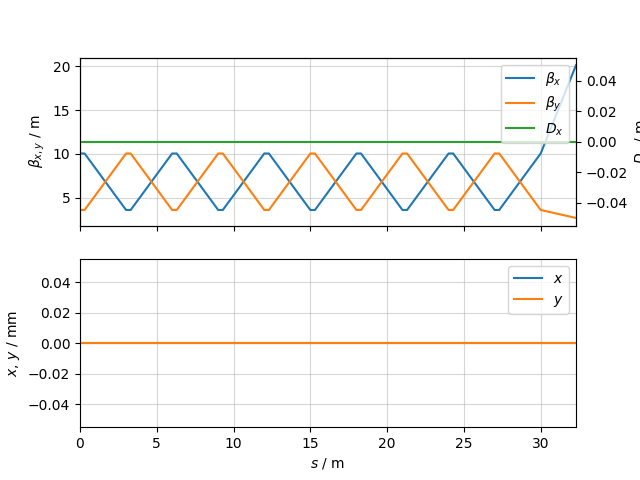

In [41]:
xplt.TwissPlot(tw)

### Matching

In [42]:
line3.element_refs['qd_2'].k1._info()

#  element_refs['qd_2'].k1._get_value()
   element_refs['qd_2'].k1 = -1.1501725360096795

#  element_refs['qd_2'].k1._expr is None

#  element_refs['qd_2'].k1 does not influence any target



In [43]:
line3.vars['kqf_3'] = line3.element_refs['qf_3'].k1._get_value()
line3.vars['kqd_3'] = line3.element_refs['qd_3'].k1._get_value()
line3.vars['kqf_4'] = line3.element_refs['qf_4'].k1._get_value()
line3.vars['kqd_4'] = line3.element_refs['qd_4'].k1._get_value()
line3.vars['kqf_5'] = line3.element_refs['qf_5'].k1._get_value()
line3.vars['kqd_5'] = line3.element_refs['qd_5'].k1._get_value()
line3.element_refs['qf_3'].k1 = line3.vars['kqf_3']
line3.element_refs['qd_3'].k1 = line3.vars['kqd_3']
line3.element_refs['qf_4'].k1 = line3.vars['kqf_4']
line3.element_refs['qd_4'].k1 = line3.vars['kqd_4']
line3.element_refs['qf_5'].k1 = line3.vars['kqf_5']
line3.element_refs['qd_5'].k1 = line3.vars['kqd_5']

In [44]:
# Match TWISS at the lattice end to: bx/y = 12 meters  and  ax/y = 0 
# Make sure the maximum betas do not exceed 30 meters 
opt3 = line3.match(
    method='4d',
    init = tw_init,
    start = 'start_line', 
    end = '_end_point',
    assert_within_tol= False,
    vary=[
        xt.VaryList(['kqf_3', 'kqd_3'], step=1e-8, tag='quad_3'),
        xt.VaryList(['kqf_4', 'kqd_4'], step=1e-8, tag='quad_4'),
        xt.VaryList(['kqf_5', 'kqd_5'], step=1e-8, tag='quad_5'),
    ],
    targets = [
        xt.TargetSet(betx = 12, bety = 12, alfx = 0, alfy = 0, at = '_end_point', tol=1e-6, tag='tune'),
    ])

Matching: model call n. 57               



In [45]:
opt3.target_status()
opt3.vary_status()

Target status:                           
id state tag  tol_met      residue  current_val target_val description                                 
 0 ON    tune    True -1.09726e-11           12         12 ('betx', '_end_point'), val=12, tol=1e-0 ...
 1 ON    tune    True -1.74705e-11           12         12 ('bety', '_end_point'), val=12, tol=1e-0 ...
 2 ON    tune    True  3.93562e-13  3.93562e-13          0 ('alfx', '_end_point'), val=0, tol=1e-06 ...
 3 ON    tune    True -1.80263e-12 -1.80263e-12          0 ('alfy', '_end_point'), val=0, tol=1e-06 ...
Vary status:                 
id state tag    met name  lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    quad_3 OK  kqf_3 None            1.45996 None              1.15017 1e-08      1
 1 ON    quad_3 OK  kqd_3 None           -1.25555 None             -1.15017 1e-08      1
 2 ON    quad_4 OK  kqf_4 None           0.928642 None              1.15017 1e-08      1
 3 ON    quad_4 OK  kqd_4 None           -1.36031 No

In [46]:
opt3.log()

Table: 8 rows, 20 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active  vary_0   vary_1 ...
        0     29.3578    -1     nnnn    yyyy          nnnnnn     yyyyyy      1.15017 -1.15017
        1     25.6126     1     nnnn    yyyy          nnnnnn     yyyyyy      1.20247 -1.09058
        2     15.2045     0     nnnn    yyyy          nnnnnn     yyyyyy      1.41285 -1.26327
        3     3.15132     0     nnnn    yyyy          nnnnnn     yyyyyy      1.41172 -1.28132
        4    0.411548     0     nnnn    yyyy          nnnnnn     yyyyyy      1.46363 -1.24666
        5  0.00894212     0     nnnn    yyyy          nnnnnn     yyyyyy      1.46012 -1.25523
        6  1.2593e-05     0     nnyy    yyyy          nnnnnn     yyyyyy      1.45996 -1.25555
        7 2.76776e-11     0     yyyy    yyyy          nnnnnn     yyyyyy      1.45996 -1.25555

### Twiss

In [47]:
tw = line3.twiss(method='4d'  ,  
                 init = tw_init,
                 start = 'start_line', 
                 end = '_end_point')


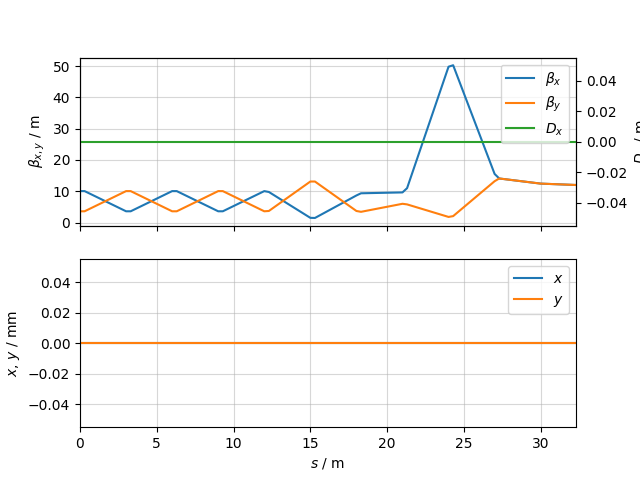

In [48]:
xplt.TwissPlot(tw)

### Matching again: Make sure the maximum betas do not exceed 30 meters 

In [49]:
opt3 = line3.match(
    method='4d',
    init = tw_init,
    start = 'start_line', 
    end = '_end_point',
    assert_within_tol= False,
    vary=[
        xt.VaryList(['kqf_3', 'kqd_3'], step=1e-8, tag='quad_3'),
        xt.VaryList(['kqf_4', 'kqd_4'], step=1e-8, tag='quad_4'),
        xt.VaryList(['kqf_5', 'kqd_5'], step=1e-8, tag='quad_5'),
    ],
    targets = [
        xt.TargetSet(betx = 12, bety = 12, alfx = 0, alfy = 0, at = '_end_point', tol=1e-6, tag='tune'),
        xt.Target(lambda tw: max(abs(tw['betx'])), xt.LessThan(30) , tol=1e-6),
        xt.Target(lambda tw: max(abs(tw['bety'])), xt.LessThan(30) , tol=1e-6),
    ])

Matching: model call n. 62               



In [50]:
opt3.target_status()
opt3.vary_status()

Target status:                           
id state tag  tol_met      residue  current_val target_val     description                                 
 0 ON    tune    True   7.8214e-09           12 12             ('betx', '_end_point'), val=12, tol=1e-0 ...
 1 ON    tune    True  8.02195e-09           12 12             ('bety', '_end_point'), val=12, tol=1e-0 ...
 2 ON    tune    True -2.28738e-09 -2.28738e-09 0              ('alfx', '_end_point'), val=0, tol=1e-06 ...
 3 ON    tune    True -3.62467e-09 -3.62467e-09 0              ('alfy', '_end_point'), val=0, tol=1e-06 ...
 4 ON            True -1.21616e-09           30 LessThan(  30) callable, val=LessThan(  30), tol=1e-06, ...
 5 ON            True            0       21.256 LessThan(  30) callable, val=LessThan(  30), tol=1e-06, ...
Vary status:                 
id state tag    met name  lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON    quad_3 OK  kqf_3 None            1.54813 None              1.45996 1e-08  

In [51]:
opt3.log()

Table: 8 rows, 22 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active  vary_0   vary_1 ...
        0     20.3035    -1     yyyyny  yyyyyy        nnnnnn     yyyyyy      1.45996 -1.25555
        1     13.6037     1     nnnnny  yyyyyy        nnnnnn     yyyyyy       1.4651 -1.38007
        2     7.33327     4     nnnnny  yyyyyy        nnnnnn     yyyyyy      1.61726 -1.54777
        3     3.28989     1     nnnnny  yyyyyy        nnnnnn     yyyyyy      1.56832 -1.68381
        4     1.84328     0     nnnnyy  yyyyyy        nnnnnn     yyyyyy      1.55083 -1.78674
        5    0.216861     0     nnnnny  yyyyyy        nnnnnn     yyyyyy      1.54927  -1.7947
        6  0.00148366     0     nnnnny  yyyyyy        nnnnnn     yyyyyy      1.54814 -1.80179
        7 4.43175e-08     0     yyyyyy  yyyyyy        nnnnnn     yyyyyy      1.54813 -1.80181

### Twiss again

In [60]:
tw = line3.twiss(method='4d'  ,  
                 init = tw_init,
                 start = 'start_line', 
                 end = '_end_point')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


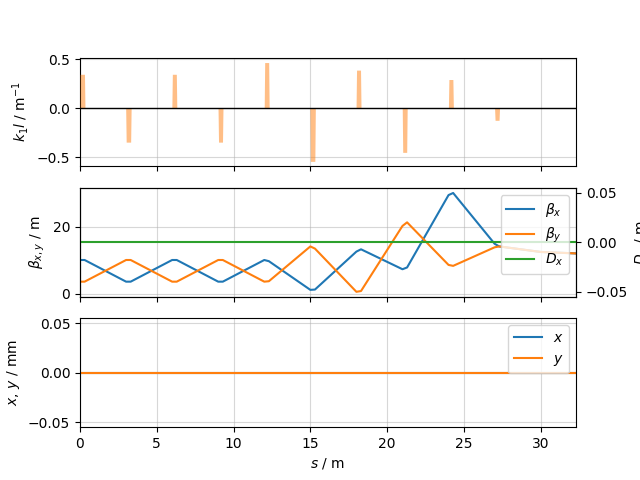

In [70]:
xplt.TwissPlot(tw, line=line3, line_kwargs={'knl': "k1l"})

In [62]:
tw.show()

name               s x px y py zeta delta ptau kin_px kin_py kin_ps kin_xprime kin_yprime    betx ...
start_line         0 0  0 0  0    0     0    0      0      0      1          0          0 10.0428
start_li_1         0 0  0 0  0    0     0    0      0      0      1          0          0 10.0428
machine$start_1    0 0  0 0  0    0     0    0      0      0      1          0          0 10.0428
qf_1               0 0  0 0  0    0     0    0      0      0      1          0          0 10.0428
od0_1            0.3 0  0 0  0    0     0    0      0      0      1          0          0 10.0428
qd_1               3 0  0 0  0    0     0    0      0      0      1          0          0 3.59038
od0:0_1          3.3 0  0 0  0    0     0    0      0      0      1          0          0 3.59038
machine$end_1      6 0  0 0  0    0     0    0      0      0      1          0          0 10.0428
start_li_2         6 0  0 0  0    0     0    0      0      0      1          0          0 10.0428
machine$start_2 